In [94]:
import os
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import cv2
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_dataset_from_directory
import random
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation, MaxPool2D, Concatenate, add, multiply
from keras.optimizers import Adam
from keras import mixed_precision
from keras import backend as K
from keras.metrics import binary_crossentropy

In [130]:
keras.backend.clear_session()

In [96]:
is_gpu_available = (len(tf.config.list_physical_devices('GPU')) > 0)
print(is_gpu_available)

#mixed_precision.set_global_policy('mixed_float16')
#os.environ["TF_ENABLE_AUTO_MIXED_PRECISION_GRAPH_REWRITE"] = "1"
#os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

True


In [97]:
fp1 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\train_data"
fp2 = r"C:\Users\Pier\Desktop\PFI_main\DS_VOLUMEN\main\validation_data"

In [98]:
batch_size = 6

---


In [103]:
def load_data(ids,suj_path,mask_path):
  suj_files = os.listdir(suj_path)
  mask_files = os.listdir(mask_path)
  X = []
  Y = []

  for i in ids:
    x = np.load(os.path.join(suj_path,suj_files[i]))
    y = np.load(os.path.join(mask_path,mask_files[i]))

    X.append(x)
    Y.append(y)

  return np.array(X), np.array(Y)

In [104]:
def batch_generator(suj_path, mask_path):
    suj_files = os.listdir(suj_path)
    indices = np.arange(len(suj_files))
    indices = np.random.permutation(indices)
    batch=[]
    while True:
            for i in indices:
                batch.append(i)
                if len(batch)==batch_size:
                    yield load_data(batch,suj_path,mask_path)
                    batch=[]

In [105]:
train_gen_ds = batch_generator(os.path.join(fp1,"sujetos"),os.path.join(fp1,"mascaras"))

val_gen_ds = batch_generator(os.path.join(fp2,"sujetos"),os.path.join(fp2,"mascaras"))

In [106]:
x,y = train_gen_ds.__next__()

In [107]:
print(x)

[[[-1.01595966 -0.7986181  -0.64669096 ... -1.10580451 -1.160691
   -1.06740557]
  [-1.00698019 -0.74970548 -0.59542407 ... -1.25320977 -1.20178267
   -1.04259819]
  [-0.93088976 -0.66919697 -0.50068838 ... -1.26231071 -1.21190533
   -1.0951107 ]
  ...
  [-0.93940119 -1.0692608  -1.09291315 ... -0.891413   -0.90174795
   -0.97651112]
  [-1.04382971 -1.05189805 -1.07419285 ... -0.90043913 -0.86883282
   -0.88169591]
  [-1.12503952 -1.09663651 -1.19178527 ... -0.85023349 -0.85391578
   -0.81651844]]

 [[-1.11445559 -1.09163775 -1.08342544 ... -0.86715555 -0.83319645
   -0.99942667]
  [-1.04271587 -0.99240453 -1.06760043 ... -0.96015286 -0.88829761
   -0.92330321]
  [-1.10677027 -1.11175797 -1.07524703 ... -1.00210102 -1.02672784
   -1.11421358]
  ...
  [-1.11325797 -1.18772759 -1.23926249 ... -1.10069652 -1.14144526
   -0.81376311]
  [-1.12229544 -1.16707539 -1.26166779 ... -0.93281055 -1.00489563
   -0.92423494]
  [-1.24496523 -1.2763373  -1.28137242 ... -0.99371167 -0.99745645
   -1.00

In [108]:
print(x.shape)
print(y.shape)
print(x.max(),x.min())
print(y.max(),y.min())

(6, 256, 256)
(6, 256, 256)
2.9459618606391174 -1.8082181490160836
1.0 0.0


<function matplotlib.pyplot.show(close=None, block=None)>

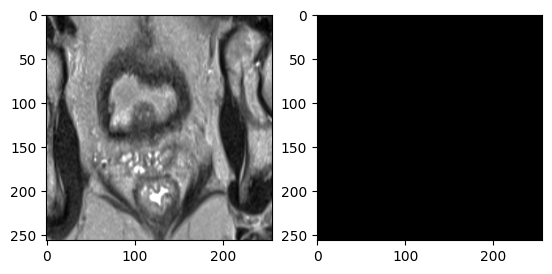

In [110]:
x,y = val_gen_ds.__next__()
image = x[0,:,:]
mask = y[0,:,:]
plt.subplot(1,2,1)
plt.imshow(image,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(mask,cmap="gray")
plt.show

In [111]:
n_train_img = len(os.listdir(os.path.join(fp1,"sujetos"))) #si es para npy saco "img"
n_val_img = len(os.listdir(os.path.join(fp2,"sujetos")))
print(n_train_img,n_val_img)
spe = n_train_img//batch_size 
vspe = n_val_img//batch_size

3971 826


---


In [132]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    #x = Dropout(0.15)(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    
    return x

def gating_signal(input, out_size, batch_norm=False):

    x = Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = add([upsample_g, theta_x])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = multiply([upsample_psi, x])

    result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = BatchNormalization()(result)
    
    return result_bn

def repeat_elem(tensor, rep):

    return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)
     
def res_conv_block(x, filter_size, size, dropout=0, batch_norm=False):

    conv = Conv2D(size, (filter_size, filter_size), padding='same')(x)
    
    conv = BatchNormalization(axis=3)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    conv = BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    #conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    shortcut = BatchNormalization(axis=3)(shortcut)

    res_path = add([shortcut, conv])
    res_path = Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    
    return res_path

In [ ]:
def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
  
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = Input(input_shape, dtype=tf.float32)


    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = MaxPooling2D(pool_size=(2,2))(conv_128)
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = MaxPooling2D(pool_size=(2,2))(conv_64)
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = MaxPooling2D(pool_size=(2,2))(conv_32)
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = MaxPooling2D(pool_size=(2,2))(conv_16)
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)


    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)

    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)

    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)


    conv_final = Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = BatchNormalization(axis=3)(conv_final)
    conv_final = Activation('sigmoid')(conv_final)  #Change to softmax for multichannel


    model = Model(inputs, conv_final, name="Attention_UNet")
    return model
my_att_unet = Attention_UNet(input_shape=(256,256,1))

In [ ]:
def Attention_ResUNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = BatchNormalization(axis=axis)(conv_final)
    conv_final = Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [133]:
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  

    model = Model(inputs, outputs, name="U-Net")
    return model
my_unet = build_unet(input_shape=(256,256,1), n_classes= 1)
  #print(my_unet.summary())

In [134]:
def DiceBCE(targets, inputs, smooth=1e-6):    
       
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    intersection = K.sum(targets * inputs)
    
    return (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)

def Jaccard(targets, inputs, smooth=1e-6):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    intersection = K.sum(K.abs(inputs * targets))
    union = K.sum(inputs) + K.sum(targets) - intersection
    
    return (intersection + smooth)/(union + smooth)

def DiceBCELoss(targets, inputs):    
    
    BCE =  binary_crossentropy(targets, inputs)
    
    return BCE + 1 - DiceBCE(targets, inputs, smooth=1e-2)

def FocalLoss(targets, inputs, alpha=0.8, gamma=2):
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    
    return alpha * K.pow((1-BCE_EXP), gamma) * BCE

In [ ]:
# from skimage.measure import label, regionprops
# from scipy.spatial.distance import directed_hausdorff

# # Calculate the Hausdorff distance between two binary images
# def hausdorff_distance(y_true, y_pred):
#     # Extract the connected components from the images
#     true_labels = label(y_true)
#     pred_labels = label(y_pred)
    
#     # Convert the images to sets of points
#     true_points = [region.coords for region in regionprops(true_labels)]
#     pred_points = [region.coords for region in regionprops(pred_labels)]
    
#     # Calculate the directed Hausdorff distance between the sets of points
#     distance = directed_hausdorff(true_points, pred_points)[0]
    
#     return distance

In [135]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    initial_lr = 0.01
    decay = 0.95
    return initial_lr * decay ** epoch

In [142]:
my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True,monitor="val_DiceBCE"),
    tf.keras.callbacks.ModelCheckpoint(filepath='modelsh5/unet_model.{epoch:02d}-{val_DiceBCE:.4f}_base_focal_doff.h5',save_best_only=True,save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=True),
    #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)
    #tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [143]:
#optimizer = tf.keras.mixed_precision.LossScaleOptimizer(Adam(learning_rate = 1e-3))
optimizer = Adam(learning_rate = 5e-3)

In [ ]:
my_unet = keras.models.load_model("modelsh5/unet_model.00-0.0166-0.7759_base_focal_.h5",custom_objects={"DiceBCE":DiceBCE,"DiceBCELoss":DiceBCELoss,"FocalLoss":FocalLoss})

In [ ]:
keras.models.Load_We

In [152]:
my_unet.load_weights("modelsh5/unet_model.11-0.6497_base_focal_doff.h5")

In [153]:
my_unet.compile(optimizer = optimizer, loss = FocalLoss, metrics = [DiceBCE,Jaccard])

In [154]:
history = my_unet.fit(train_gen_ds,
                    verbose=1, 
                    steps_per_epoch=spe,
                    epochs=100,
                    validation_data=val_gen_ds, 
                    validation_steps=vspe,
                    callbacks=my_callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/100
661/661 [==============================] - 317s 476ms/step - loss: 6.8172e-04 - DiceBCE: 0.3104 - Jaccard: 0.1898 - val_loss: 6.8795e-04 - val_DiceBCE: 0.3481 - val_Jaccard: 0.2192 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 2/100
661/661 [==============================] - 284s 430ms/step - loss: 3.8863e-04 - DiceBCE: 0.4038 - Jaccard: 0.2617 - val_loss: 0.0027 - val_DiceBCE: 0.4083 - val_Jaccard: 0.2676 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 3/100
661/661 [==============================] - 278s 420ms/step - loss: 2.4297e-04 - DiceBCE: 0.4779 - Jaccard: 0.3239 - val_loss: 3.7908e-04 - val_DiceBCE: 0.4316 - val_Jaccard: 0.2862 - lr: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 4/100
661/661 [==============================] - 282s 427ms/step

In [141]:
history.history['val_DiceBCE']

[0.1157730221748352,
 0.31176483631134033,
 0.42073431611061096,
 0.42082321643829346,
 0.429561048746109,
 0.5722036957740784,
 0.5433778166770935,
 0.563554048538208,
 0.5505870580673218,
 0.6473495364189148,
 0.6497437953948975]

In [24]:
my_unet.save("modelsh5/unet_model.06-0.0000-0.8274_base_focal_.h5")

In [ ]:
#my_unet.evaluate()

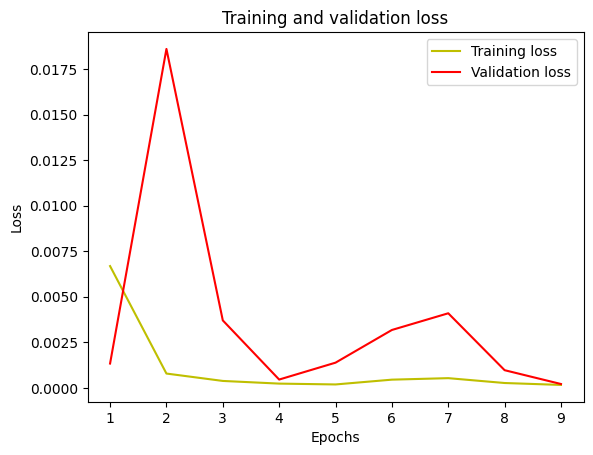

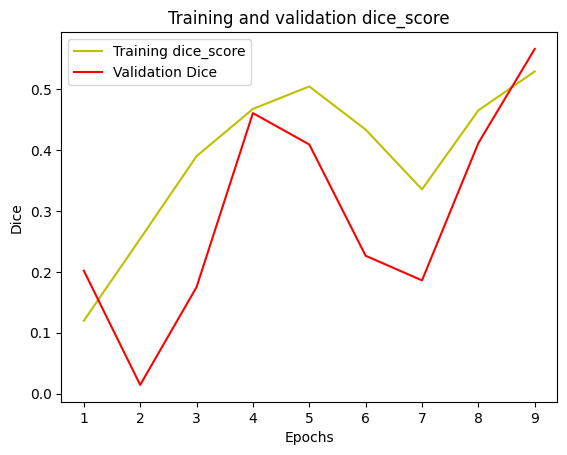

In [121]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['DiceBCE']
val_acc = history.history['val_DiceBCE']

plt.plot(epochs, acc, 'y', label='Training dice_score')
plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation dice_score')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

1/1 [==============================] - 0s 27ms/step
Mean IoU = 1.0


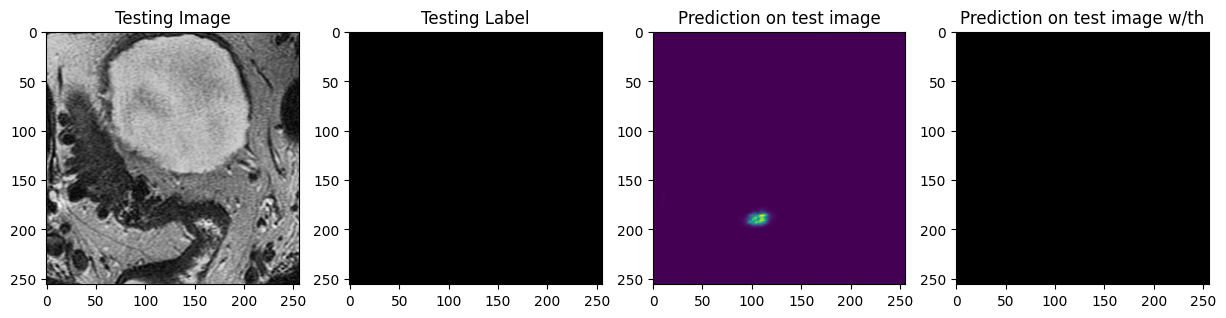

In [93]:
test_image_batch, test_mask_batch = val_gen_ds.__next__()
test_img_number = random.randint(0, len(test_image_batch)-1)
test_img = test_image_batch[test_img_number]
ground_truth=test_mask_batch[test_img_number]
test_img_norm=test_img[:,:]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (my_unet.predict(test_img_input))
predicted_img_th = prediction[0,:,:,0]>0.5

IOU_keras = MeanIoU(num_classes=2)  
IOU_keras.update_state(ground_truth, predicted_img_th)
print("Mean IoU =", IOU_keras.result().numpy())

plt.figure(figsize=(15, 10))
plt.subplot(241)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(242)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(243)
plt.title('Prediction on test image')
plt.imshow(prediction[0,:,:,0])
plt.subplot(244)
plt.title('Prediction on test image w/th')
plt.imshow(predicted_img_th, cmap='gray')
plt.show()